In [66]:
pip install ccxt pandas numpy matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [67]:
# Import data from Binance
import ccxt
import pandas as pd
import time

# Initialize Binance API
binance = ccxt.binance()

def fetch_binance_data(symbol='BTC/USDT', timeframe='3m', limit=100):
    """Fetch historical OHLCV i.e. "Open" "High" "Low" "Close" and "Volume" data from Binance"""
    bars = binance.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Fetch & display data
btc_data = fetch_binance_data()
print(btc_data.tail())

             timestamp      open      high       low     close     volume
95 2025-02-27 19:36:00  83849.50  83865.07  83701.51  83865.06   88.77447
96 2025-02-27 19:39:00  83865.07  83931.49  83728.62  83808.35  114.20449
97 2025-02-27 19:42:00  83808.36  83953.60  83720.00  83938.01   69.44147
98 2025-02-27 19:45:00  83937.33  84110.36  83917.04  84003.03   73.20448
99 2025-02-27 19:48:00  84003.02  84003.03  84003.02  84003.03    0.03062


In [68]:
import numpy as np

def add_indicators(df):
    """Compute technical indicators like RSI (Relative Strength Index) and Moving Averages"""
    df['SMA_10'] = df['close'].rolling(window=10).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    return df
    
def compute_rsi(series, period=14):
    delta = series.diff()  # Price change between consecutive time steps
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc_data['RSI'] = compute_rsi(btc_data['close'])

btc_data = add_indicators(btc_data)
print(btc_data.tail())



             timestamp      open      high       low     close     volume  \
95 2025-02-27 19:36:00  83849.50  83865.07  83701.51  83865.06   88.77447   
96 2025-02-27 19:39:00  83865.07  83931.49  83728.62  83808.35  114.20449   
97 2025-02-27 19:42:00  83808.36  83953.60  83720.00  83938.01   69.44147   
98 2025-02-27 19:45:00  83937.33  84110.36  83917.04  84003.03   73.20448   
99 2025-02-27 19:48:00  84003.02  84003.03  84003.02  84003.03    0.03062   

          RSI     SMA_10      SMA_50  
95  21.271993  84086.406  84543.1910  
96  22.713642  84027.443  84527.0510  
97  31.065552  83996.696  84513.3888  
98  37.698313  83978.999  84500.4968  
99  36.125265  83945.430  84489.8644  


In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [70]:
# Prepare dataset
def prepare_data(df):
    data = df[['close', 'SMA_10', 'SMA_50', 'RSI']].dropna().values
    X, y = [], []
    for i in range(10, len(data)):
        X.append(data[i-10:i])
        y.append(data[i][0])  # Predict next closing price
    return np.array(X), np.array(y)

X, y = prepare_data(btc_data)

In [71]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X, y, epochs=10, batch_size=16)


Epoch 1/10
3/3 [==============================] - 2s 15ms/step - loss: 7133449728.0000
Epoch 2/10
3/3 [==============================] - 0s 10ms/step - loss: 7133372416.0000
Epoch 3/10
3/3 [==============================] - 0s 10ms/step - loss: 7133289984.0000
Epoch 4/10
3/3 [==============================] - 0s 8ms/step - loss: 7133199360.0000
Epoch 5/10
3/3 [==============================] - 0s 8ms/step - loss: 7133095936.0000
Epoch 6/10
3/3 [==============================] - 0s 9ms/step - loss: 7132978176.0000
Epoch 7/10
3/3 [==============================] - 0s 8ms/step - loss: 7132848128.0000
Epoch 8/10
3/3 [==============================] - 0s 8ms/step - loss: 7132715008.0000
Epoch 9/10
3/3 [==============================] - 0s 8ms/step - loss: 7132589568.0000
Epoch 10/10
3/3 [==============================] - 0s 7ms/step - loss: 7132474880.0000


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential



In [73]:
# Normalize features for better LSTM performance
scaler = MinMaxScaler()

# Initialize separate scalers for the close price and technical indicators
close_scaler = MinMaxScaler()
feature_scaler = MinMaxScaler()

# Fit scalers separately
btc_data[['close']] = close_scaler.fit_transform(btc_data[['close']])
btc_data[['SMA_10', 'SMA_50', 'RSI']] = feature_scaler.fit_transform(btc_data[['SMA_10', 'SMA_50', 'RSI']])



In [74]:
# Prepare dataset for LSTM
def prepare_data(df):
    data = df[['close', 'SMA_10', 'SMA_50', 'RSI']].dropna().values
    X, y = [], []
    for i in range(10, len(data)):
        X.append(data[i-10:i])  # Use past 10 timesteps as input
        y.append(data[i][0])  # Predict next closing price
    return np.array(X), np.array(y)

In [75]:
X, y = prepare_data(btc_data)

# Reshape data for LSTM input format (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (41, 10, 4)
y shape: (41,)


In [76]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),  # Extra dense layer for better learning
    Dense(1)  # Output layer predicting the next close price
])

model.compile(optimizer='adam', loss='mse')


In [77]:
# Train model
history = model.fit(X, y, epochs=10, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/10
3/3 [==============================] - 3s 289ms/step - loss: 0.1249 - val_loss: 0.0026
Epoch 2/10
3/3 [==============================] - 0s 24ms/step - loss: 0.0436 - val_loss: 0.0051
Epoch 3/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0202
Epoch 4/10
3/3 [==============================] - 0s 16ms/step - loss: 0.0192 - val_loss: 0.0244
Epoch 5/10
3/3 [==============================] - 0s 19ms/step - loss: 0.0194 - val_loss: 0.0163
Epoch 6/10
3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - val_loss: 0.0092
Epoch 7/10
3/3 [==============================] - 0s 21ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 8/10
3/3 [==============================] - 0s 21ms/step - loss: 0.0116 - val_loss: 0.0054
Epoch 9/10
3/3 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0061
Epoch 10/10
3/3 [==============================] - 0s 19ms/step - loss: 0.0102 - val_loss: 0.0079


In [78]:
# Predict on full dataset
predictions = model.predict(X)



2/2 [==============================] - 1s 4ms/step


In [79]:
# Inverse transform to get real prices
btc_data['Predicted_Close'] = np.nan  # Initialize column

btc_data.iloc[-len(predictions):, btc_data.columns.get_loc('Predicted_Close')] = close_scaler.inverse_transform(
    predictions.reshape(-1, 1)  # Reshape for scaler
)[:, 0]  # Extract first column (Predicted Close)


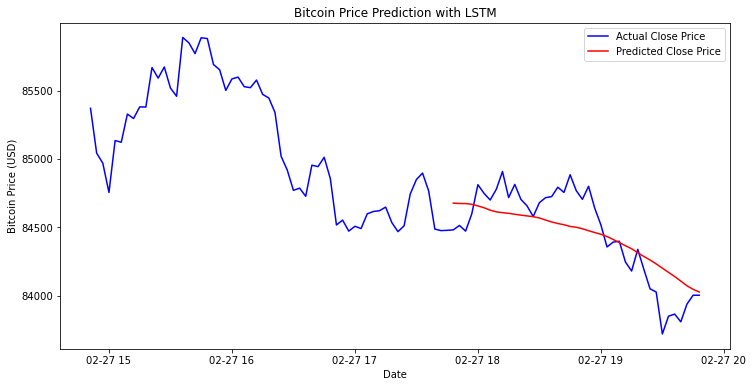

In [80]:
# Inverse transform actual close prices before plotting
btc_data['Actual_Close'] = close_scaler.inverse_transform(
    btc_data[['close']]
)

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(btc_data['timestamp'], btc_data['Actual_Close'], label="Actual Close Price", color='blue')
plt.plot(btc_data['timestamp'], btc_data['Predicted_Close'], label="Predicted Close Price", color='red')
plt.xlabel("Date")
plt.ylabel("Bitcoin Price (USD)")
plt.legend()
plt.title("Bitcoin Price Prediction with LSTM")
plt.show()


In [81]:
def predict_next_price(model, last_10_steps):
    """Predict Bitcoin price using the last 10 observations."""
    last_10_steps = scaler.transform(last_10_steps)  # Normalize
    last_10_steps = last_10_steps.reshape(1, last_10_steps.shape[0], last_10_steps.shape[1])  # Reshape
    predicted_price = model.predict(last_10_steps)
    return scaler.inverse_transform(
        np.column_stack((predicted_price, np.zeros((1, 3))))
    )[0, 0]  # Extract first column

In [82]:
# Get last 10 time steps
last_10_steps = btc_data[['close', 'SMA_10', 'SMA_50', 'RSI']].dropna().values[-10:]


In [83]:
def predict_next_price(model, btc_data, close_scaler, feature_scaler):
    """Predict the next Bitcoin price using the last 10 time steps."""

    # Select the last 10 time steps for prediction
    last_10_steps = btc_data[['close', 'SMA_10', 'SMA_50', 'RSI']].dropna().values[-10:]
    
    # Separate close price and technical indicators
    last_10_close = last_10_steps[:, 0].reshape(-1, 1)  # Extract close price column
    last_10_indicators = last_10_steps[:, 1:]  # Extract SMA_10, SMA_50, RSI
    
    # Scale the close price and indicators separately
    last_10_close_scaled = close_scaler.transform(last_10_close)
    last_10_indicators_scaled = feature_scaler.transform(last_10_indicators)
    
    # Combine scaled close price and indicators back into one array
    last_10_steps_scaled = np.hstack((last_10_close_scaled, last_10_indicators_scaled))

    # Reshape for LSTM model (samples=1, timesteps=10, features=4)
    last_10_steps_scaled = last_10_steps_scaled.reshape(1, last_10_steps_scaled.shape[0], last_10_steps_scaled.shape[1])
    
    # Predict next normalized closing price
    predicted_price_normalized = model.predict(last_10_steps_scaled)
    
    # Inverse transform the predicted price to the original scale
    predicted_price_actual = close_scaler.inverse_transform(
        predicted_price_normalized.reshape(-1, 1)  # Reshape for scaler
    )[0, 0]  # Extract the first value

    return predicted_price_actual



In [84]:
next_price = predict_next_price(model, btc_data, close_scaler, feature_scaler)
print(f"🚀 Predicted Next Bitcoin Price: ${next_price:.2f}")

1/1 [==============================] - 0s 20ms/step
🚀 Predicted Next Bitcoin Price: $82847.13


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
